# Computational Illustration for Chapter 07: Clustering

## Illustration of the single-linkage and Lloyd's algorithms

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

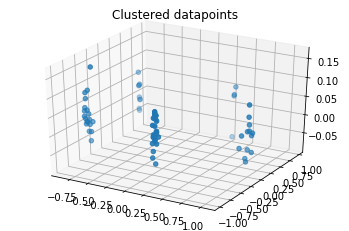

In [2]:
# generate clustered data
k = 5                                           # number of clusters 
M = np.random.randint(25, size=k)               # numbers of datapoints per cluster
m = sum(M)                                      # total number of datapoints
X = np.empty((3,0))                             # dxm matrix to hold the datapoints (d=3)
for h in range(k):
    center_h = [np.cos(2*np.pi/k*h), np.sin(2*np.pi/k*h), .05*np.random.rand()]
    radius_h = np.random.rand()/k
    X_h = np.row_stack((center_h[0]+radius_h*np.random.normal(size=M[h]),
                        center_h[1]+radius_h*np.random.normal(size=M[h]),
                        center_h[2]+.05*np.random.normal(size=M[h])))
    X = np.column_stack((X,X_h))
# shuffle the datapoints
X = X[:,np.random.permutation(m)]  
# store all pairwise distances into a matrix
dist = np.zeros((m,m))
for i in range(m):
    for j in range(m):
        dist[i,j] = LA.norm(X[:,i]-X[:,j])
# visualize the original clusters
ax = plt.axes(projection="3d")
ax.scatter3D(X[0,:],X[1,:],X[2,:])
plt.title('Clustered datapoints')
plt.show()

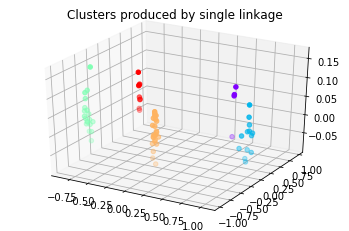

In [3]:
# naive implementation of the single-linkage algorithm
partition_sl = np.identity(m)                                   # its columns will hold the clusters
for t in range(m-k):
    d = 2*np.max(dist)*np.ones((m-t,m-t))                       # matrix of distances between clusters
    for i in range(m-t-1):
        C_i = np.nonzero(partition_sl[:,i])[0]
        for j in range(i+1,m-t):
            C_j = np.nonzero(partition_sl[:,j])[0]
            aux1 = dist[C_i,:]
            aux2 = aux1[:,C_j]
            aux3 = np.min(aux2)
            d[i,j] = aux3
            d[j,i] = aux3
    j = np.argmin(np.min(d,axis=0))
    i = np.argmin(d[:,j])
    partition_sl[:,i] = partition_sl[:,i]+partition_sl[:,j]     # merge C_i,C_j
    partition_sl = np.delete(partition_sl,j,axis=1)             # remove C_j
# visualize the outputted clusters    
ax = plt.axes(projection="3d")
colors = matplotlib.cm.rainbow(np.linspace(0,1,k))
for h in range(k):
    C_h = np.nonzero(partition_sl[:,h])[0]
    ax.scatter3D(X[0,C_h],X[1,C_h],X[2,C_h],color=colors[h])
plt.title('Clusters produced by single linkage')
plt.show()

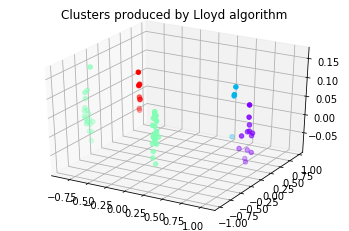

In [4]:
# naive implementation of Lloyd's algorithm
centers = np.row_stack(( np.random.uniform(-2,2,size=(2,k)),np.zeros((1,k)) ))
partition_l = np.zeros((m,k))
n_iters = 100
for t in range(n_iters):
    dist = np.zeros((k,m))
    for h in range(k):
        for i in range(m):
            dist[h,i] = LA.norm(X[:,i]-centers[:,h])
    aux = np.argmin(dist,axis=0)
    for h in range(k):
        C_h = np.where(aux==h)[0]
        partition_l[:,h] = (aux==h)
        if np.size(C_h)>0:
            centers[:,h] = np.sum(X[:,C_h],axis=1)/np.size(C_h)
# visualize the outputted clusters 
ax = plt.axes(projection="3d")
colors = matplotlib.cm.rainbow(np.linspace(0,1,k))
for h in range(k):
    C_h = np.nonzero(partition_l[:,h])[0]
    if np.size(C_h)>0:
        ax.scatter3D(X[0,C_h],X[1,C_h],X[2,C_h],color=colors[h])
plt.title('Clusters produced by Lloyd algorithm')
plt.show()

# Illustration of spectral clustering

In [5]:
from scipy.linalg import eigh

In [6]:
# generate two communites and their connections with the stochastic block model
m = 500
perm = np.random.permutation(m)
comm1 = perm[:int(m/2)]
comm1.sort()
comm2 = perm[int(m/2):]
comm2.sort()
# define an auxiliary 0/1-matrix whose entries = 1 w.proba=p
p = 1/4
aux1 = np.array(np.random.rand(int(m/2),int(m/2))<p, dtype=int)
# define an auxiliary 0/1-matrix whose entries = 1 w.proba=q
q = 3/4
aux2 = np.array(np.random.rand(int(m/2),int(m/2))<q, dtype=int)
aux2l = np.tril(aux2)-np.diag(np.diag((aux2)))    # lower triangular part without the diagonal
aux2u = np.triu(aux2)-np.diag(np.diag((aux2)))    # upper triangular part without the diagonal
# define the random adjacency matrix W
W = np.zeros((m,m))
W[np.ix_(comm1,comm1)] = aux2l + aux2l.transpose()
W[np.ix_(comm1,comm2)] = aux1
W[np.ix_(comm2,comm1)] = aux1.transpose()
W[np.ix_(comm2,comm2)] = aux2u + aux2u.transpose()

In [7]:
# Cluster according to the leading eigenvector of W - delta*ones(n,n)
delta = np.sum(W)/(m*m)
e,E = eigh(W-delta*np.ones((m,m)),eigvals=(m-1,m-1))
c_sp1 = [idx for idx,val in enumerate(E) if val>0]
c_sp2 = [idx for idx,val in enumerate(E) if val<=0]
# determine the percentage of errors made
c_sp1_set = set(c_sp1)
c_sp2_set = set(c_sp2)
n1 = len(c_sp1_set.intersection(comm1)) + len(c_sp2_set.intersection(comm2))
n2 = len(c_sp2_set.intersection(comm1)) + len(c_sp1_set.intersection(comm2))
print('Percentage of error:', 100*min(n1,n2)/m, '%')

Percentage of error: 0.0 %


#### There seems to be no errors at all when m is large enough!
### Empirical estimation of the error percentage depending on m, p, and q

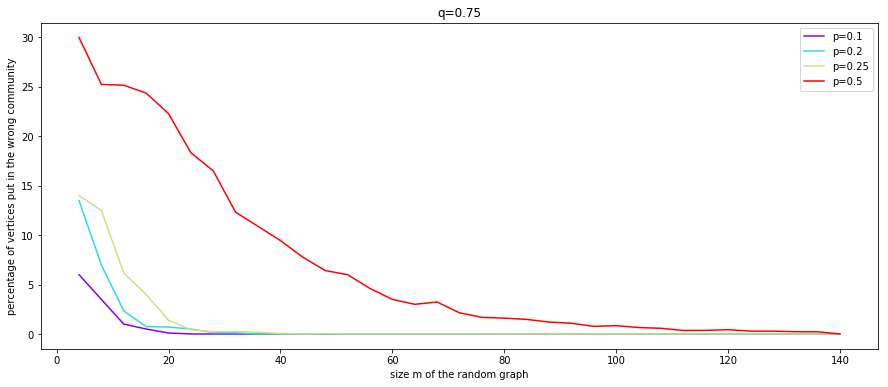

In [8]:
# parameters for the range of values of m to be tested
m_min = 4
m_max = 140
m_inc = 4
# number of random trials performed for a given m
n_trials = 50
# fix one value of q and consider several values of p
q = 3/4
p_values = [1/10,1/5,1/4,1/2]
# matrix to store the percentage of errors
perc_errors = np.zeros( (int( 1+(m_max-m_min)/m_inc),len(p_values)) )
# loop reproducing the above code
for j in range(len(p_values)):
    for m in range(m_min,m_max,m_inc):
        err = 0
        for t in range(n_trials):
            perm = np.random.permutation(m)
            comm1 = perm[:int(m/2)]  
            comm1.sort()
            comm2 = perm[int(m/2):] 
            comm2.sort()
            aux1 = np.array(np.random.rand(int(m/2),int(m/2))<p_values[j], dtype=int)
            aux2 = np.array(np.random.rand(int(m/2),int(m/2))<q, dtype=int)
            aux2l = np.tril(aux2)-np.diag(np.diag((aux2)))
            aux2u = np.triu(aux2)-np.diag(np.diag((aux2)))
            W = np.zeros((m,m))
            W[np.ix_(comm1,comm1)] = aux2l + aux2l.transpose()
            W[np.ix_(comm1,comm2)] = aux1
            W[np.ix_(comm2,comm1)] = aux1.transpose()
            W[np.ix_(comm2,comm2)] = aux2u + aux2u.transpose()
            delta = np.sum(W)/(m*m)
            e,E = eigh(W-delta*np.ones((m,m)),eigvals=(m-1,m-1))
            c_sp1 = [idx for idx,val in enumerate(E) if val>0]
            c_sp2 = [idx for idx,val in enumerate(E) if val<=0]
            c_sp1_set = set(c_sp1)
            c_sp2_set = set(c_sp2)
            n1 = len(c_sp1_set.intersection(comm1)) + len(c_sp2_set.intersection(comm2))
            n2 = len(c_sp2_set.intersection(comm1)) + len(c_sp1_set.intersection(comm2))
            err += min(n1,n2)
        perc_errors[int((m-m_min)/m_inc),j] = 100*err/(m*n_trials)
# visualize the results
fig = plt.figure(figsize=(15,6))
colors = matplotlib.cm.rainbow(np.linspace(0,1,len(p_values)))
for j in range(len(p_values)):
    plt.plot(np.linspace(m_min,m_max,int((m_max-m_min)/m_inc)+1),perc_errors[:,j],color=colors[j])
plt.xlabel('size m of the random graph')
plt.ylabel('percentage of vertices put in the wrong community')
plt.title('q='+str(q))
leg = []
for j in range(len(p_values)):
    leg.append('p='+str(p_values[j]))
plt.legend(leg,loc='upper right')
plt.show()